In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Dropout, add, Input, Dense, LSTM
import string
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, to_categorical

from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_dir = "/content/drive/MyDrive/Project"
desc_dir = "/content/drive/MyDrive/InfoProject/descriptions.txt"

In [ ]:
jpgs = os.listdir(image_dir)
print("No of .jpg flies in the Dataset: {}".format(len(jpgs)))

No of .jpg flies in the Dataset: 7793


In [ ]:
with open(desc_dir, 'r') as file:
    text = file.read()

data = []
for line in text.split('\n')[1:]:
    token = line.split(',')
    if len(token) < 2:
        continue
    data.append([token[0], token[1].lower()])

# Create a DataFrame
df_desc = pd.DataFrame(data, columns=["imgname", "description"])

uni_names = np.unique(df_desc['imgname'].values)

print("No of Unique Image File Names:", len(uni_names))

No of Unique Image File Names: 8091


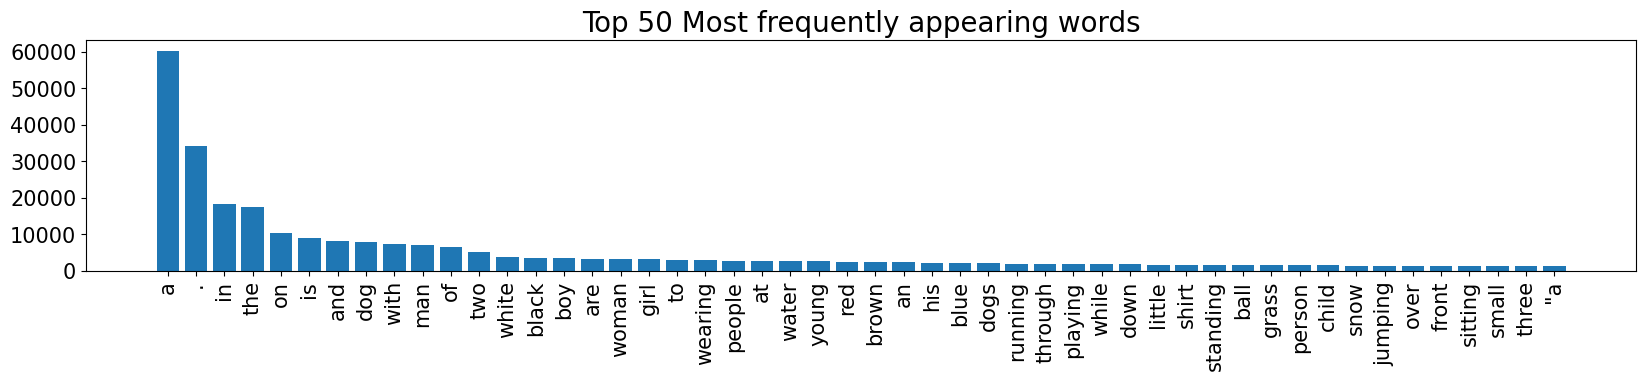

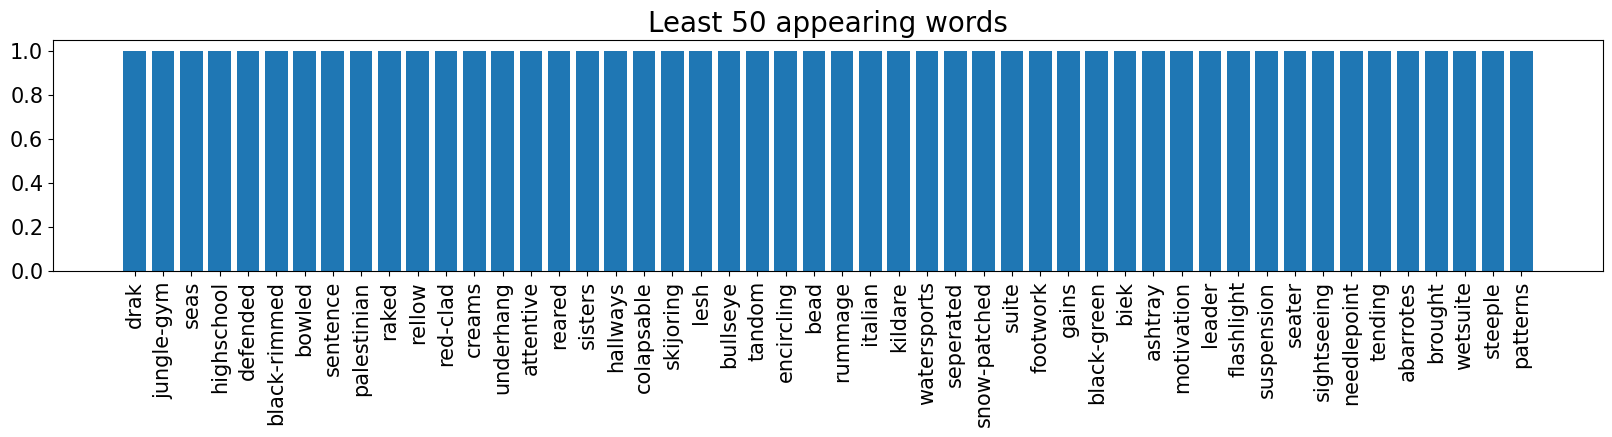

In [ ]:
# Extract vocabulary and count frequency
def df_word(df_desc):
    vocab = []
    for desc in df_desc['description']:
        vocab.extend(desc.split())
    cnt = Counter(vocab)
    word_df = pd.DataFrame({"words": list(cnt.keys()), "count": list(cnt.values())})
    word_df = word_df.sort_values("count", ascending=False)
    word_df = word_df.reset_index()[["words", "count"]]
    return word_df

word_df = df_word(df_desc)
no_of_words = 50

# Plotting function for word frequency
def plot_hist(dfsub, title):
    plt.figure(figsize=(20, 3))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=15)
    plt.xticks(dfsub.index, dfsub["words"], rotation=90, fontsize=15)
    plt.title(title, fontsize=20)
    plt.show()

# Plot most and least frequent words
plot_hist(word_df.iloc[:no_of_words, :], "Top 50 Most frequently appearing words")
plot_hist(word_df.iloc[-no_of_words:, :], "Least 50 appearing words")

In [ ]:
# Define functions for text cleaning
def eliminate_punctuation(original_text):
    text_elim_punc = original_text.translate(str.maketrans('', '', string.punctuation))
    return text_elim_punc

In [ ]:
def delete_one_character(original_text):
    return " ".join([txt for txt in original_text.split() if len(txt) > 1])

In [ ]:
def delete_numeric(original_text):
    return " ".join([txt for txt in original_text.split() if txt.isalpha()])

In [ ]:
def clean_text(original_text):
    text = eliminate_punctuation(original_text)
    text = delete_one_character(original_text)
    text = delete_numeric(original_text)
    return text

# Clean Descriptions
for i, desc in enumerate(df_desc.description.values):
    df_desc["description"].iloc[i] = clean_text(desc)

In [ ]:
def add_start_end_token(desc):
    return ['start ' + txt + ' end' for txt in desc]

df_desc["description"] = add_start_end_token(df_desc["description"])
#df_desc.head(5)

In [ ]:
def load_descriptions():
    descriptions = {}
    for index, row in df_desc.iterrows():
        img_id, img_desc = row['imgname'], row['description']
        img_id = img_id.split('.')[0]

        if img_id not in descriptions:
            descriptions[img_id] = []

        descriptions[img_id].append(img_desc)
    return descriptions

In [ ]:
# Load the ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(dir):
    features = {}
    for name in os.listdir(dir):
        fname = dir + '/' + name
        image = load_img(fname, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = resnet_model.predict(image, verbose=0)
        features[name.split('.')[0]] = feature
    return features

# Extract features from all images
features = extract_features(image_dir)


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
def build_tokenizer(descriptions):
    tokens = [desc for key in descriptions.keys() for desc in descriptions[key]]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tokens)
    return tokenizer

def max_desc_length(descriptions):
    tokens = [desc for key in descriptions.keys() for desc in descriptions[key]]
    return max(len(d.split()) for d in tokens)

descriptions = load_descriptions()
tokenizer = build_tokenizer(descriptions)
vocabulary_size = len(tokenizer.word_index) + 1
max_desc_length = max_desc_length(descriptions)


In [ ]:
vocabulary_size
max_desc_length

8194

In [ ]:
max_desc_length

35

In [ ]:
def narration_model(vocabulary_size, max_desc_length):
    # Feature extractor (from ResNet50)
    finput1 = Input(shape=(2048,))
    flayer1 = Dropout(0.4)(finput1)
    flayer2 = Dense(256, activation='relu')(flayer1)

    # Sequence model
    sinput2 = Input(shape=(max_desc_length,))
    slayer1 = Embedding(vocabulary_size, 256, mask_zero=True)(sinput2)
    slayer2 = Dropout(0.4)(slayer1)
    slayer3 = LSTM(256)(slayer2)

    # Decoder model
    declayer1 = add([flayer2, slayer3])
    declayer2 = Dense(256, activation='relu')(declayer1)
    outputs = Dense(vocabulary_size, activation='softmax')(declayer2)

    # Merge the two input models
    model = Model(inputs=[finput1, sinput2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = narration_model(vocabulary_size, max_desc_length)


In [ ]:
def DataGenerator(descriptions, features, tokenizer, max_desc_length):
    while True:
        for key, desc_list in descriptions.items():
            # Retrieve image features
            feature = features[key][0]
            in_img, in_seq, out_word = generate_sequences(tokenizer, max_desc_length, desc_list, feature)
            yield [[in_img, in_seq], out_word]

def generate_sequences(tokenizer, max_desc_length, desc_list, feature):
    Z1, Z2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_desc_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocabulary_size)[0]
            Z1.append(feature)
            Z2.append(in_seq)
            y.append(out_seq)
    return np.array(Z1), np.array(Z2), np.array(y)

In [ ]:
epochs = 20
batch_size = 32

steps = len(descriptions) // batch_size

# Train the model
generator = DataGenerator(descriptions, features, tokenizer, max_desc_length)
hist = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)


Epoch 1/20
252/252 [==============================] - 45s 142ms/step - loss: 5.6132
Epoch 2/20
252/252 [==============================] - 33s 132ms/step - loss: 4.9639
Epoch 3/20
252/252 [==============================] - 33s 132ms/step - loss: 4.5953
Epoch 4/20
252/252 [==============================] - 33s 130ms/step - loss: 4.3951
Epoch 5/20
252/252 [==============================] - 32s 125ms/step - loss: 4.1611
Epoch 6/20
252/252 [==============================] - 31s 125ms/step - loss: 4.0677
Epoch 7/20
252/252 [==============================] - 32s 127ms/step - loss: 3.9528
Epoch 8/20
252/252 [==============================] - 32s 125ms/step - loss: 3.9747
Epoch 9/20
252/252 [==============================] - 32s 129ms/step - loss: 3.8831
Epoch 10/20
252/252 [==============================] - 33s 129ms/step - loss: 3.7911
Epoch 11/20
252/252 [==============================] - 32s 128ms/step - loss: 3.9448
Epoch 12/20
252/252 [==============================] - 32s 128ms/step - lo

In [ ]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
def extract_feature_for_single_image(image_path, resnet_model):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = resnet_model.predict(image, verbose=0)
    return feature

In [ ]:
def predict_narration(model, tokenizer, img_features, max_desc_length=35):
    start_text = 'start'
    for i in range(max_desc_length):
        sequence = tokenizer.texts_to_sequences([start_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_desc_length)
        yhat = model.predict([img_features, sequence], verbose=0)
        yhat = np.argmax(yhat, axis=-1)
        word = index_to_word(yhat, tokenizer)
        if word is None or word == 'end':
            break
        start_text += ' ' + word
    return start_text

In [ ]:
def generate_narration(img_name):

    img_features = extract_feature_for_single_image(img_name, resnet_model)

    description = predict_narration(model, tokenizer, img_features, max_desc_length)

    return description

In [ ]:
def get_actual_descriptions(img_name, df_desc):
    img_name = os.path.basename(img_name)
    actual_desc = df_desc[df_desc['imgname'] == img_name]['description'].tolist()
    return actual_desc

In [ ]:
def display_image_desc_bleu(img_name, df_desc, model, tokenizer, resnet_model, max_desc_length, image_dir):
    pred_desc = generate_narration(img_name)
    pred_desc = pred_desc.split()
    pred_desc = pred_desc[1:]


    actual_desc = get_actual_descriptions(img_name, df_desc)
    actual_descs_processed = []
    for desc in actual_desc:
        desc_tokens = desc.split()
        desc_tokens = desc_tokens[1:-1]
        actual_descs_processed.append(desc_tokens)

    bleu_score = sentence_bleu(actual_descs_processed, pred_desc) if actual_descs_processed else 0
    pred_desc = ' '.join(pred_desc)
    actual_descs = ' / '.join([' '.join(desc) for desc in actual_descs_processed])

    image = Image.open(img_name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print("Actual Descriptions:", actual_descs)
    print("Predicted Description:", pred_desc)
    print("BLEU Score:", bleu_score)


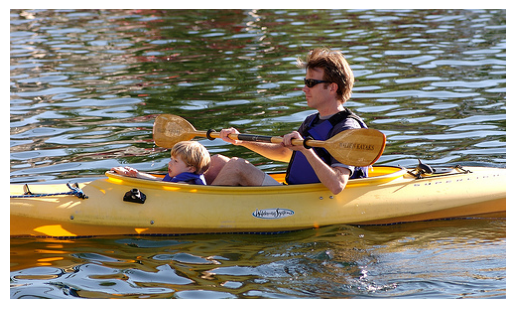

True Descriptions: a man and a baby are in a yellow kayak on water / a man and a little boy in blue life jackets are rowing a yellow canoe / a man and child kayak through gentle waters / a man and young boy ride in a yellow kayak / man and child in yellow kayak
Predicted Description: a man in a blue shirt is riding a wave
BLEU Score: 9.013778876140909e-155


In [ ]:
img_name = "/content/drive/MyDrive/Project/1028205764_7e8df9a2ea.jpg"
display_image_desc_bleu(img_name, df_desc, model, tokenizer, resnet_model, max_desc_length, image_dir)

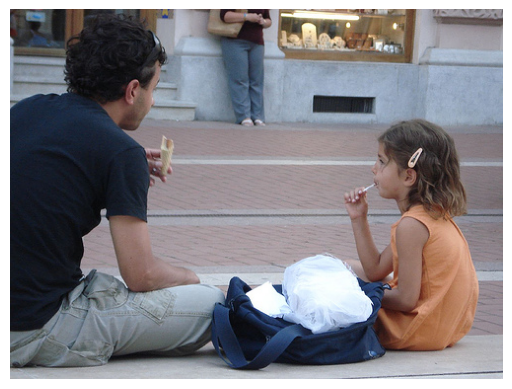

Actual Descriptions: a man and a girl sit on the ground and eat / a man and a little girl are sitting on a sidewalk near a blue bag eating / a man and young girl eat a meal on a city street / a man wearing a black shirt and a girl wearing an orange shirt sitting on the pavement eating / a man wearing a black shirt and a little girl wearing an orange dress share a treat
Predicted Description: man and girl sit on the ground near a blue bag
BLEU Score: 0.6389431042462724


In [ ]:
img_name = "/content/drive/MyDrive/Project/191003285_edd8d0cf58.jpg"
display_image_desc_bleu(img_name, df_desc, model, tokenizer, resnet_model, max_desc_length, image_dir)

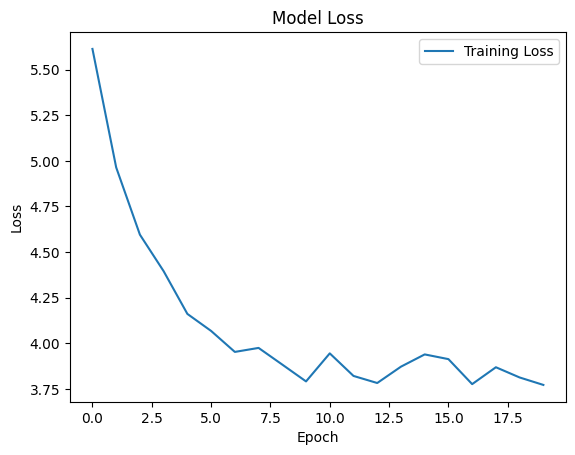

In [ ]:
if 'val_loss' in hist.history:
    plt.plot(hist.history['val_loss'], label='Validation Loss')

plt.plot(hist.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

grouped = df_desc.groupby('imgname')['description'].apply(list).reset_index()
train, test = train_test_split(grouped, test_size=0.2, random_state=42)

In [ ]:
f_train = train['imgname'].tolist()
f_test = test['imgname'].tolist()

# Extract features and tokenized descriptions for the test set
d_test = {ft: features[ft] for ft in f_test if ft in features}
# Extract descriptions for the test set
test_desc = df_desc[df_desc['imgname'].isin(f_test)]

In [ ]:
d_test = {}
for img_name in f_test:
    img_desc = test_desc[test_desc['imgname'] == img_name]['description'].tolist()
    d_test[img_name] = [tokenizer.texts_to_sequences([desc])[0] for desc in img_desc]

In [ ]:
index_word = {index: word for word, index in tokenizer.word_index.items()}

In [ ]:
nkeep = 5
good_pred_img, bad_pred_img, bleus = [], [], []

for jpgft in f_test:

    img_feature = d_test.get(jpgft)
    if not img_feature:  # Skip if no features are found for the image
        continue

    for tokenized_text in d_test[jpgft]:
        desc_true = [index_word[i] for i in tokenized_text if i in index_word]
        desc_true = desc_true[1:-1]

        # Generate narration
        img_features = extract_feature_for_single_image(os.path.join(image_dir, jpgft), resnet_model)
        desc = predict_narration(model, tokenizer, img_features, max_desc_length)
        desc = desc.split()[1:-1]

        # Calculate BLEU score
        bleu = sentence_bleu([desc_true], desc)
        bleus.append(bleu)

        if bleu > 0.7 and len(good_pred_img) < nkeep:
            good_pred_img.append((bleu, jpgft, desc_true, desc))
        elif bleu < 0.3 and len(bad_pred_img) < nkeep:
            bad_pred_img.append((bleu, jpgft, desc_true, desc))

mean_bleu = np.mean(bleus) if bleus else 0
print("The Mean BLEU Value for the Test Set is {:4.3f}".format(mean_bleu))

The Mean BLEU Value for the Test Set is 0.381
